In [873]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution
from astropy.modeling.models import Voigt1D
import warnings
from __future__ import print_function
from pylab import *
import math
from astropy.io import fits, ascii
from astropy.table import Table
import pyfits, time, itertools, random, os, sys, glob, re

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

%matplotlib inline

## Organize files by instrument

### COS

1. Split all downloaded spectra for one target into different gratings

2. Co-add and average spectra from same grating for one target

3. Read in proper grating lsf

4. Select correct wavelength columns for each UV line

5. Measure fluxes for that target

### STIS

1. Split all downloaded spectra for one target into different gratings

2. Decide correct wavelength to use for particular line

3. Load in appropriate grating lsf

4. Determine aperture used for each spectrum

5. Use the correct aperture column to convolve fits for one line

In [874]:
def ready_lsf(orig_lsf_wave, orig_lsf , grating_disp, data_wave):
    data_wave_spacing = data_wave[1]-data_wave[0] # number of Å per pixel
    data_wave_length = len(data_wave) # number of wavelength values
    lsf_lam_min = np.round(np.min(orig_lsf_wave*grating_disp)/data_wave_spacing) * data_wave_spacing
    lsf_lam_onesided = np.arange(lsf_lam_min,0,data_wave_spacing)  ### Make sure it's even and doesn't include zero
    if len(lsf_lam_onesided) % 2 != 0:
        lsf_lam_onesided = lsf_lam_onesided[1::] # get rid of the first element of the array

    lsf_lam_flipped = lsf_lam_onesided[::-1]
    lsf_lam_pluszero=np.append(lsf_lam_onesided,np.array([0]))
    lsf_lam=np.append(lsf_lam_pluszero,lsf_lam_flipped) # should be odd

    lsf_interp = np.interp(lsf_lam,orig_lsf_wave*grating_disp,orig_lsf/np.sum(orig_lsf))
    lsf_interp_norm = lsf_interp/np.sum(lsf_interp) # I don't know why I do np.sum() for normalization...

    if data_wave_length < len(lsf_interp_norm):
        lsf_interp_norm = np.delete(lsf_interp_norm,np.where(lsf_interp_norm == 0))
        lsf_interp_norm = np.insert(lsf_interp_norm,0,0)
        lsf_interp_norm = np.append(lsf_interp_norm,0)

    return lsf_interp_norm

##################################################################

#Defining a functions
def gaussian(x, amp, cen, wid):
    model =  amp*np.exp(-(x-cen)**2/(2*wid**2))
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

def double_gauss(x, amp1, cen1, wid1, amp2, cen2, wid2):
    model = amp1*np.exp(-(x-cen1)**2/(2*wid1**2)) + amp2*np.exp(-(x-cen2)**2/(2*wid2**2))
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

##################################################################

def sse_g(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    g_fit = gaussian(wave, *parameterTuple)
    return np.sum((flux - g_fit)**2) #/ g_fit)

def generate_p0_g(peak_flux, line, window):
    parameterBounds = []
    parameterBounds.append([(peak_flux)*0.9, (peak_flux)*1.1]) # parameter bounds for amp  
    parameterBounds.append([line, line]) # parameter bounds for cen
    parameterBounds.append([0, 0.5]) # parameter bounds for wid
    #parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_g, parameterBounds)#, seed=2019)
    return result.x

def sse_dg(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    dg_fit = double_gauss(wave, *parameterTuple)
    return np.sum((flux - dg_fit)**2) #/ dg_fit)

def generate_p0_dg(amp1, amp2, cen1, cen2, window):
    parameterBounds = []
    parameterBounds.append([(amp1)*0.9, (amp1)*1.1]) # parameter bounds for amp  
    parameterBounds.append([cen1, cen1]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    parameterBounds.append([(amp2)*0.9, (amp2)*1.1]) # parameter bounds for amp  
    parameterBounds.append([cen2, cen2]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    #parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_dg, parameterBounds)#, seed=2019)
    return result.x

In [875]:
line_names = ["SiIII", "NV", "SiII", "CII", "SiIV", "CIV", "HeII", "MgII"]
line_waves = [[1206.50], [1238.82,1242.8060], [1260.42,1265.00], [1335.71],  
              [1393.76,1402.77], [1548.19,1550.78], [1640.4], [2800.0]]
line_windows = [[1], [2,2], [0.7,1], [0.7], [1,1], [1,1], [1], [20]]

# Might need to use alternate, wider windows for STIS
line_windows = [[2], [2,2], [0.7,1], [0.7], [1,1], [1,1], [1], [20]]

all_lines = ["SiIII", "NV", "NV", "SiII", "SiII", "CII", "SiIV", "SiIV", "CIV", "CIV", "HeII", "MgII"]

cos_grating_proxies = [["1200"], ["1250"], ["1250"], ["1350"], ["1400"], ["1550"], ["1650"], ["2800"]]

lines_cos_gratings = {"SiIII": ["G130M"], "NV": ["G130M"], "SiII": ["G130M"], "CII": ["G130M"],
                      "SiIV": ["G130M"], "CIV": ["G160M"], "HeII": ["G160M"], "MgII": ["NUV"]}

lines_cos_columns = {"SiIII": [2], "NV": [3], "SiII": [3], "CII": [5], 
                     "SiIV": [6], "CIV": [3], "HeII": [5], "MgII": [12]}

stis_grating_proxies = ["1200", "1200", "1200", "1200", "1500", "1500", "1700", "2400"]

lines_stis_gratings = {"SiIII": ["G140L", "G140M", "E140M"], "NV": ["G140L", "G140M", "E140M"], 
                       "SiII": ["G140L", "E140M"], "CII": ["G140L", "E140M"],
                       "SiIV": ["G140L", "E140M"], "CIV": ["G140L", "E140M"], 
                       "HeII": ["G140L", "G230L", "E140M"], "MgII": ["G230L"]}

colors=["mediumslateblue", "firebrick", "peachpuff"]

uv_targets = ["GJ628", "GJ887", "GJ1061", "HD173739", "G75-55", "GJ173", "LP5-282", "2MASSJ02001277-0840516", 
              "GJ3470", "GJ3053", "GJ676A", "GJ649", "GJ674", "GJ729", "K2-25"] # GJ3053 alternate name for LHS1140

In [923]:
# "test_uv_spectra" are UV files from GJ173 copied into different folder

star = "K2-25"

all_rvs = ascii.read('RVs.txt')
target_rv = float(all_rvs["rv"][all_rvs["target_name"]==star][0]) * 10**13
c = 299792458e10

cos_spectra = glob.glob("Spectra/%s/l*.fits" % star)
stis_spectra = glob.glob("Spectra/%s/o*.fits" % star)
print(cos_spectra)
print(stis_spectra)

[]
['Spectra/K2-25/od9001020_x1d.fits', 'Spectra/K2-25/od9003010_x1d.fits', 'Spectra/K2-25/od9004020_x1d.fits', 'Spectra/K2-25/od9006010_x1d.fits', 'Spectra/K2-25/od9002030_x1d.fits', 'Spectra/K2-25/od9001030_x1d.fits', 'Spectra/K2-25/od9005010_x1d.fits', 'Spectra/K2-25/od9002020_x1d.fits', 'Spectra/K2-25/od9005020_x1d.fits', 'Spectra/K2-25/od9006030_x1d.fits', 'Spectra/K2-25/od9003020_x1d.fits', 'Spectra/K2-25/od9001010_x1d.fits', 'Spectra/K2-25/od9005030_x1d.fits', 'Spectra/K2-25/od9006020_x1d.fits', 'Spectra/K2-25/od9004010_x1d.fits']


## COS FITTING

In [914]:
all_cos_NUV_gratings = ["G185M", "G285M", "G230L"] # "G225M" only one that doesn't include ANY spectral line in range

all_cos_gratings = {"cos_G130M": [], "cos_G140L": [], "cos_G160M": [], "cos_NUV": []}

cos_spectra_and_gratings = []

for i in range(len(cos_spectra)):
    cos_hdu = pyfits.open(cos_spectra[i])

    cos_grating = cos_hdu[0].header["OPT_ELEM"]
    #print(cos_grating)
    
    if cos_grating in all_cos_NUV_gratings:
        cos_grating = "NUV"
    
    all_cos_gratings["cos_%s" % cos_grating].append(cos_spectra[i])
    cos_spectra_and_gratings.append([cos_spectra[i],cos_grating])

cos_spectra_and_gratings = np.array(cos_spectra_and_gratings)
print(all_cos_gratings)
print(cos_spectra_and_gratings)

{'cos_NUV': [], 'cos_G140L': [], 'cos_G160M': [], 'cos_G130M': ['Spectra/GJ674/ldlm20miq_x1d.fits', 'Spectra/GJ674/ldlm20mbq_x1d.fits', 'Spectra/GJ674/ldlm20moq_x1d.fits', 'Spectra/GJ674/ldlm20m9q_x1d.fits', 'Spectra/GJ674/ldlm20mmq_x1d.fits']}
[['Spectra/GJ674/ldlm20miq_x1d.fits' 'G130M']
 ['Spectra/GJ674/ldlm20mbq_x1d.fits' 'G130M']
 ['Spectra/GJ674/ldlm20moq_x1d.fits' 'G130M']
 ['Spectra/GJ674/ldlm20m9q_x1d.fits' 'G130M']
 ['Spectra/GJ674/ldlm20mmq_x1d.fits' 'G130M']]


SiIII
[[1206.5]]
[[2]]
Spectra/GJ674/ldlm20miq_x1d.fits G130M 2
Fitting gaussian
Spectra/GJ674/ldlm20mbq_x1d.fits G130M 2
Fitting gaussian
Spectra/GJ674/ldlm20moq_x1d.fits G130M 2
Fitting gaussian
Spectra/GJ674/ldlm20m9q_x1d.fits G130M 2
Fitting gaussian
Spectra/GJ674/ldlm20mmq_x1d.fits G130M 2
Fitting gaussian
402
402
Number of peaks: 1
Peak:  1206.5
[  1.28001343e-13   1.20645510e+03   8.64044727e-02]
[  1.32193493e-15   9.45747502e-04   1.06452561e-03]
GAUSSIAN FLUX: 2.77230294321e-14
ERROR (GAUSSIAN FLUX): 4.45682723703e-16


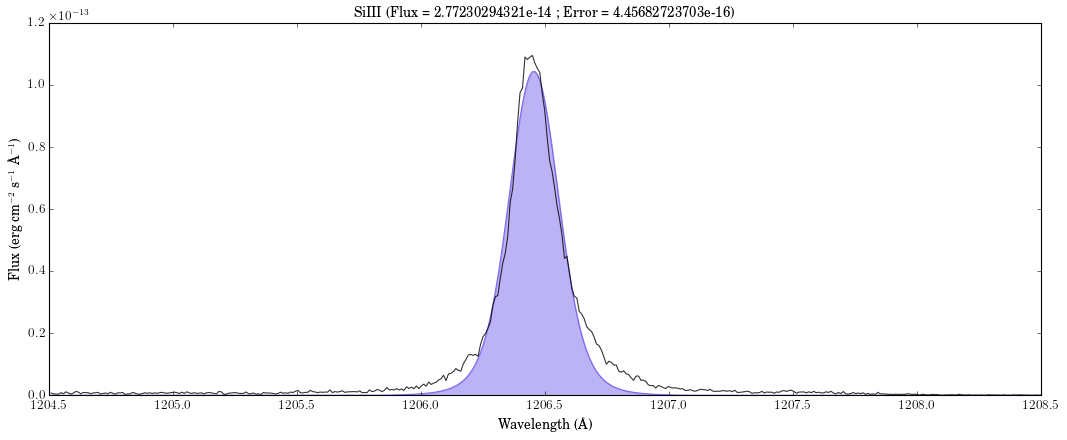

NV
[[1238.82, 1242.806]]
[[2, 2]]
Spectra/GJ674/ldlm20miq_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20mbq_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20moq_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20m9q_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20mmq_x1d.fits G130M 3
Fitting gaussian
802
802
Number of peaks: 2
Peak:  1238.82
[  8.03154511e-14   1.23877217e+03   7.05087282e-02]
[  5.67387187e-16   5.16751935e-04   5.91038523e-04]
GAUSSIAN FLUX: 1.41948863006e-14
ERROR (GAUSSIAN FLUX): 1.55609250511e-16
Number of peaks: 2
Peak:  1242.806
[  3.69168138e-14   1.24276839e+03   7.73364160e-02]
[  4.27634726e-16   9.40224114e-04   1.06552618e-03]
GAUSSIAN FLUX: 7.15645898455e-15
ERROR (GAUSSIAN FLUX): 1.28818439503e-16


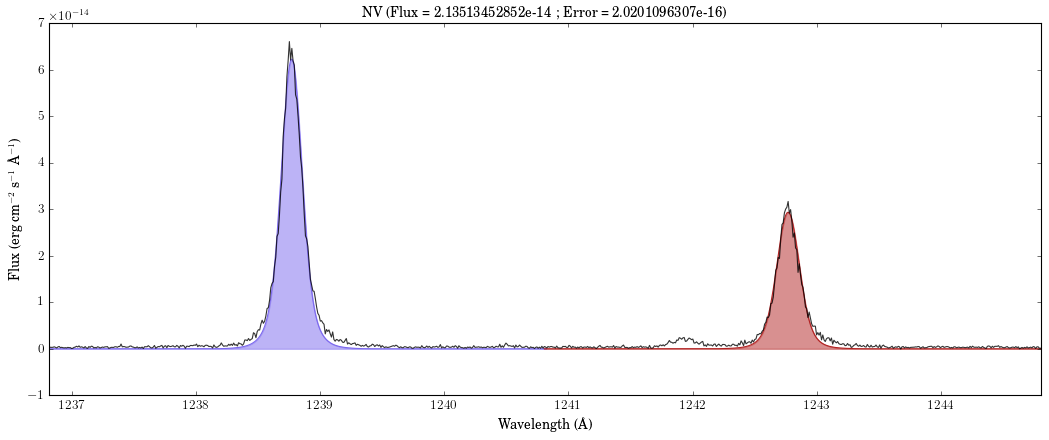

SiII
[[1260.42, 1265.0]]
[[0.7, 1]]
Spectra/GJ674/ldlm20miq_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20mbq_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20moq_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20m9q_x1d.fits G130M 3
Fitting gaussian
Spectra/GJ674/ldlm20mmq_x1d.fits G130M 3
Fitting gaussian
660
660
Number of peaks: 2
Peak:  1260.42
[  4.65914490e-15   1.26039318e+03   9.88389146e-02]
[  2.54094180e-16   5.80482269e-03   6.43901014e-03]
GAUSSIAN FLUX: 1.15431441507e-15
ERROR (GAUSSIAN FLUX): 9.80713181847e-17
Number of peaks: 2
Peak:  1265.0
Fitting a double gaussian
[  1.02747164e-14   1.26469924e+03   6.58594167e-02   5.30046788e-15
   1.26496963e+03   6.34759953e-02]
[  3.06282681e-16   2.22517103e-03   2.67242778e-03   3.18259306e-16
   4.30631884e-03   5.17199784e-03]
DOUBLE GAUSSIAN FLUX:  2.53956362458e-15
ERROR (DOUBLE GAUSSIAN FLUX):  1.20748236968e-16


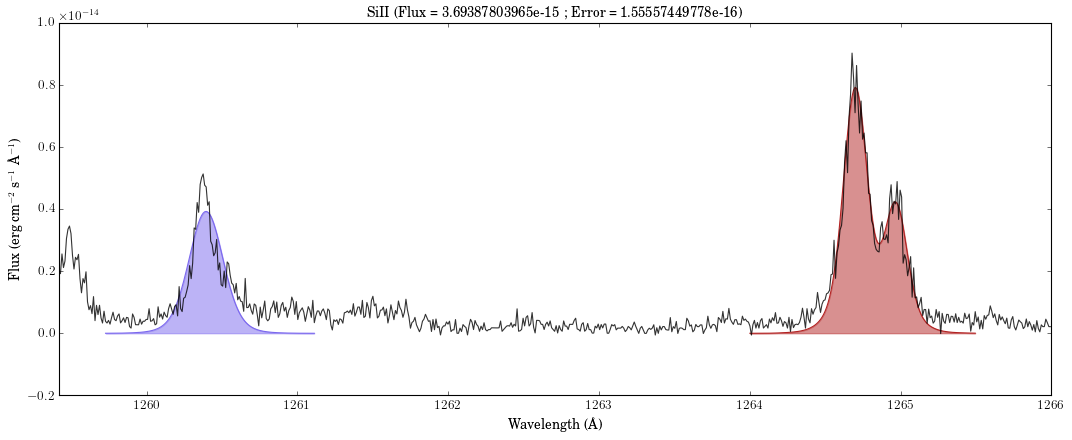

CII
[[1335.71]]
[[0.7]]
Spectra/GJ674/ldlm20miq_x1d.fits G130M 5
Fitting gaussian
Spectra/GJ674/ldlm20mbq_x1d.fits G130M 5
Fitting gaussian
Spectra/GJ674/ldlm20moq_x1d.fits G130M 5
Fitting gaussian
Spectra/GJ674/ldlm20m9q_x1d.fits G130M 5
Fitting gaussian
Spectra/GJ674/ldlm20mmq_x1d.fits G130M 5
Fitting gaussian
141
141
Number of peaks: 1
Peak:  1335.71
[  1.23523046e-13   1.33566445e+03   8.71395855e-02]
[  1.46682589e-15   1.10811552e-03   1.23160234e-03]
GAUSSIAN FLUX: 2.698071268e-14
ERROR (GAUSSIAN FLUX): 4.98065958436e-16


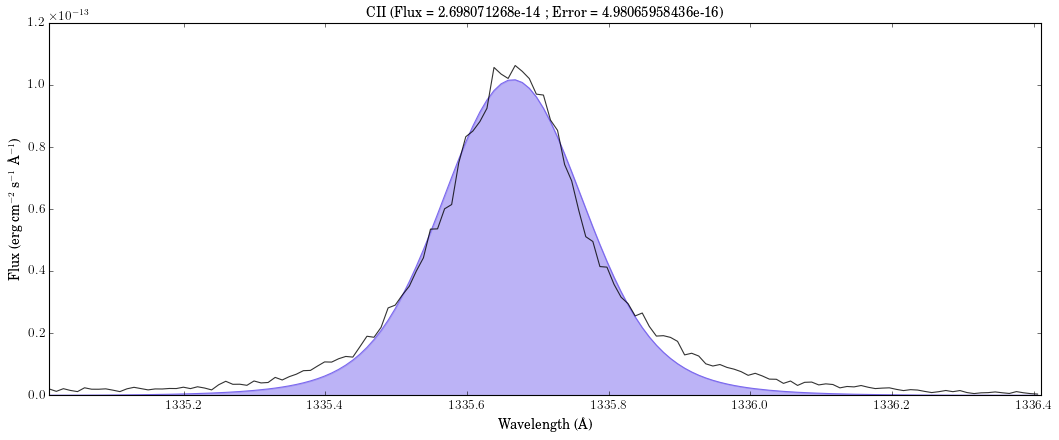

SiIV
[[1393.76, 1402.77]]
[[1, 1]]
Spectra/GJ674/ldlm20miq_x1d.fits G130M 6
Peak not in range -- cannot fit line
Spectra/GJ674/ldlm20mbq_x1d.fits G130M 6
Peak not in range -- cannot fit line
Spectra/GJ674/ldlm20moq_x1d.fits G130M 6
Peak not in range -- cannot fit line
Spectra/GJ674/ldlm20m9q_x1d.fits G130M 6
Peak not in range -- cannot fit line
Spectra/GJ674/ldlm20mmq_x1d.fits G130M 6
Peak not in range -- cannot fit line
No COS observations for this line
CIV
[[1548.19, 1550.78]]
[[1, 1]]
No COS observations for this line
HeII
[[1640.4]]
[[1]]
No COS observations for this line
MgII
[[2800.0]]
[[20]]
No COS observations for this line


In [915]:
#line_names = ["CIV"]
#line_waves = [[1548.19,1550.78]]
#line_windows = [[1,1]]

all_cos_total_fluxes = []
all_cos_total_fluxes_err = []
all_fluxes = []
all_fluxes_err = []
all_fit_params = []
all_fit_params_err = []

for line in line_names:
    print(line)
    
    peaks = np.array(line_waves)[np.array(line_names)==line]
    print(peaks)
    
    windows = np.array(line_windows)[np.array(line_names)==line]
    print(windows)
    
    all_line_waves = []
    all_line_fluxes = []
    
    for j in range(len(lines_cos_gratings[line])):
        #print(grating)
        
        for i in range(len(cos_spectra_and_gratings)):
            grating = lines_cos_gratings[line][j]
            column = lines_cos_columns[line][j]
            
            if grating == cos_spectra_and_gratings[i][1]:
                spectrum = cos_spectra_and_gratings[i][0]
                print(spectrum, grating, column)
                
                cos_hdu = pyfits.open(spectrum)
                wave = np.ravel(cos_hdu[1].data["WAVELENGTH"]) / (1 + target_rv / c)
                flux = np.ravel(cos_hdu[1].data["FLUX"])
                err = np.ravel(cos_hdu[1].data["ERROR"])
                
                index_range = np.where((wave > np.array(peaks[0][0])-max(np.array(windows[0]))) & 
                                       (wave < np.array(peaks[0][-1])+max(np.array(windows[0]))))
                
                lsf = np.loadtxt("HST_Gratings/cos_%s.txt" % grating, skiprows=1)
                dispersion = wave[1]-wave[0] # number of Å per pixel
                lsf_kernel = ready_lsf(lsf[:,0], lsf[:,column], dispersion, wave)
                
                #If the mean of the first 10% of values or last 10% of values is zero, cut that spectrum
                short_lo_flux = flux[index_range][:(0.2*len(flux[index_range]))]
                short_hi_flux = flux[index_range][:-(0.2*len(flux[index_range]))]
                
                if (mean(short_lo_flux) == 0 or mean(short_hi_flux) == 0):
                    print("Flat in range -- cannot fit line")
                    plt.figure()
                    plt.plot(wave,flux, color="red")
                    plt.xlim(np.array(peaks[0][0])-max(np.array(windows[0])),np.array(peaks[0][-1])+max(np.array(windows[0])))
                    plt.ylim(0,1.1*max(flux[index_range]))
                    plt.ticklabel_format(useOffset=False)
                    plt.show()
                    plt.close()
                elif len(short_lo_flux) == 0:
                    print("Peak not in range -- cannot fit line")
                else:
                    print("Fitting gaussian")
                    """plt.figure()
                    plt.plot(wave,flux, color="green")
                    plt.xlim(np.array(peaks[0][0])-max(np.array(windows[0])),np.array(peaks[0][-1])+max(np.array(windows[0])))
                    plt.ylim(0,1.1*max(flux[index_range]))
                    plt.ticklabel_format(useOffset=False)
                    plt.show()
                    plt.close()"""
                    
                    #print(len(wave[index_range]), len(flux[index_range]))
                    all_line_waves.append(wave[index_range])
                    all_line_fluxes.append(flux[index_range])
    
    # Not fitting anything for lines where no grating available matched that line
    if len(all_line_waves) == 0:
        print("No COS observations for this line")
        
        for j in range(len(peaks[0])):
            all_fit_params.append(np.zeros(6))
            all_fit_params_err.append(np.zeros(6))
            all_fluxes.append(0)
            all_fluxes_err.append(0)
    
    else:
        min_wave = np.min(all_line_waves[0])
        max_wave = np.max(all_line_waves[-1])

        wave_array = np.linspace(min_wave,max_wave,len(all_line_fluxes[0]))

        all_line_interp = []
        for i in range(len(all_line_waves)):
            line_interp = np.interp(wave_array,all_line_waves[i],all_line_fluxes[i])
            all_line_interp.append(line_interp)

        avg_flux = np.mean(all_line_interp, axis=0)
        print(len(wave_array))
        print(len(avg_flux))

        #############################################
        #####     NOW FIT CO-ADDED SPECTRA     #####
        #############################################

        plt.figure(figsize=(16,6))
        plt.xlabel("Wavelength (\AA)")
        plt.ylabel("Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)")
        plt.xlim(np.array(peaks[0][0])-max(np.array(windows[0])),np.array(peaks[0][-1])+max(np.array(windows[0])))
        plt.ticklabel_format(useOffset=False)

        line_total_integral = []
        line_total_integral_err = []
        fit_parameters = []
        fit_err_parameters = []

        wave = wave_array
        flux = avg_flux

        for j in range(len(peaks[0])):
            print("Number of peaks:", len(peaks[0]))
            peak = peaks[0][j]
            window = windows[0][j]
            print("Peak: ", peak)

            if peak == 1265.0:
                print("Fitting a double gaussian")
                amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
                amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])

                p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)

                popt_dg, pcov_dg = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                           np.array(flux[(wave<1265.5) & (wave>1264)]), p0 = p0_dg, maxfev=2500)
                popt_dg_err = np.sqrt(np.diag(pcov_dg))
                
                print(popt_dg)
                print(popt_dg_err)

                fit_parameters.append(popt_dg)
                fit_err_parameters.append(popt_dg_err)
                all_fit_params.append(popt_dg)
                all_fit_params_err.append(popt_dg_err)

                dg = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                             popt_dg[0], popt_dg[1], abs(popt_dg[2]), popt_dg[3], popt_dg[4], abs(popt_dg[5])) #, popt_g[6])

                int_dg = popt_dg[0] * popt_dg[2] * np.sqrt(2*pi) + popt_dg[3] * popt_dg[5] * np.sqrt(2*pi)
                int_dg_err = np.sqrt((np.sqrt(2*pi))**2 * (popt_dg_err[0]**2 * popt_dg[2]**2 + popt_dg_err[2]**2 * popt_dg[0]**2 
                                                   + popt_dg_err[3]**2 * popt_dg[5]**2 + popt_dg_err[5]**2 * popt_dg[3]**2))

                all_fluxes.append(int_dg)
                all_fluxes_err.append(int_dg_err)
                line_total_integral.append(int_dg)
                print("DOUBLE GAUSSIAN FLUX: ", int_dg)
                line_total_integral_err.append(int_dg_err)
                print("ERROR (DOUBLE GAUSSIAN FLUX): ", int_dg_err)

                plt.plot(wave[(wave<1265.5) & (wave>1264)], dg, alpha=1, color=colors[j])
                plt.fill_between(wave[(wave<1265.5) & (wave>1264)], dg, alpha=0.5, color=colors[j]) #label="Double Gaussian",

            elif peak == 2800.0:
                print("Fitting a double gaussian")
                amp1 = np.max(flux[(wave<2799) & (wave>2795)])
                amp2 = np.max(flux[(wave<2806) & (wave>2801)])

                p0_dg = generate_p0_dg(amp1, amp2, 2796.35, 2803.53, window)

                popt_dg, pcov_dg = curve_fit(double_gauss, np.array(wave[(wave<(peak+window)) & (wave>(peak-window))]), 
                                           np.array(flux[(wave<(peak+window)) & (wave>(peak-window))]), p0 = p0_dg, maxfev=2500)
                popt_dg_err = np.sqrt(np.diag(pcov_dg))
                print(popt_dg)
                print(popt_dg_err)

                fit_parameters.append(popt_dg)
                fit_err_parameters.append(popt_dg_err)
                all_fit_params.append(popt_dg)
                all_fit_params_err.append(popt_dg_err)

                dg = double_gauss(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                             popt_dg[0], popt_dg[1], abs(popt_dg[2]), popt_dg[3], popt_dg[4], abs(popt_dg[5]))

                int_dg = popt_dg[0] * popt_dg[2] * np.sqrt(2*pi) + popt_dg[3] * popt_dg[5] * np.sqrt(2*pi)
                int_dg_err = np.sqrt((np.sqrt(2*pi))**2 * (popt_dg_err[0]**2 * popt_dg[2]**2 + popt_dg_err[2]**2 * popt_dg[0]**2 
                                                   + popt_dg_err[3]**2 * popt_dg[5]**2 + popt_dg_err[5]**2 * popt_dg[3]**2))

                all_fluxes.append(int_dg)
                all_fluxes_err.append(int_dg_err)
                line_total_integral.append(int_dg)
                print("DOUBLE GAUSSIAN FLUX: ", int_dg)
                line_total_integral_err.append(int_dg_err)
                print("ERROR (DOUBLE GAUSSIAN FLUX): ", int_dg_err)

                plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], dg, alpha=1, color=colors[j])
                plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                 dg, alpha=0.5, color=colors[j]) #label="Double Gaussian",

            else:
                peak_flux = np.max(flux[(wave<(peak+0.2)) & (wave>(peak-0.2))])

                p0_g = generate_p0_g(peak_flux, peak, window)

                #param_bounds=([peak_flux*.8,line-0.1,0,0],[peak_flux*1.2,line+0.1,0.8,0])
                popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                           flux[(wave<(peak+window)) & (wave>(peak-window))], p0 = p0_g, maxfev=2500)
                popt_g_err = np.sqrt(np.diag(pcov_g))
                print(popt_g)
                print(popt_g_err)

                fit_parameters.append(np.concatenate((popt_g, np.zeros(3))))
                fit_err_parameters.append(np.concatenate((np.sqrt(np.diag(pcov_g)), np.zeros(3))))
                all_fit_params.append(np.concatenate((popt_g, np.zeros(3))))
                all_fit_params_err.append(np.concatenate((np.sqrt(np.diag(pcov_g)), np.zeros(3))))

                g = gaussian(wave[(wave<(peak+window)) & (wave>(peak-window))], popt_g[0], popt_g[1], abs(popt_g[2]))

                int_g = popt_g[0] * abs(popt_g[2]) * np.sqrt(2*pi)
                int_g_err = np.sqrt((np.sqrt(2*pi))**2 * (popt_g_err[0]**2 * popt_g[2]**2 + popt_g_err[2]**2 * popt_g[0]**2))

                all_fluxes.append(int_g)
                all_fluxes_err.append(int_g_err)
                line_total_integral.append(int_g)
                print("GAUSSIAN FLUX:", int_g)
                line_total_integral_err.append(int_g_err)
                print("ERROR (GAUSSIAN FLUX):", int_g_err)

                plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], g, alpha=1, color=colors[j])
                plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                 g, alpha=0.5, color=colors[j]) #label="Gaussian",
            
        all_cos_total_fluxes.append(sum(line_total_integral))
        all_cos_total_fluxes_err.append(np.sqrt(sum(np.array(line_total_integral_err)**2)))

        #plt.ylim(0,1.1*np.max(flux[(wave<(peaks[0][-1]+np.max(peaks[0]))) & (wave>(peaks[0]-np.max(peaks[0])))]))
        total_flux = sum(line_total_integral)
        total_flux_err = np.sqrt(sum(np.array(line_total_integral_err)**2))
        plt.plot(wave_array, avg_flux, alpha=0.8, color="black")
        #legend = plt.legend(loc="best", fontsize=12)
        plt.title(r"%s (Flux = %s ; Error = %s)" % (line, total_flux, total_flux_err))
        plt.savefig("Graphs/%s_cos_%s" % (star, line))
        plt.show()

In [916]:
print(all_line_fluxes)

[]


In [918]:
all_fit_params = np.array(all_fit_params)
all_fit_params_err = np.array(all_fit_params_err)

all_names = ['line', 'all_fluxes', 'all_fluxes_err',
             'amp1', 'amp1_err', 'cen1', 'cen1_err', 'wid1', 'wid1_err',
             'amp2', 'amp2_err', 'cen2', 'cen2_err', 'wid2', 'wid2_err']
data = Table({'line': all_lines, 'all_fluxes': all_fluxes, 'all_fluxes_err': all_fluxes_err,
              'amp1': all_fit_params[:,0], 'amp1_err': all_fit_params_err[:,0],
              'cen1': all_fit_params[:,1], 'cen1_err': all_fit_params_err[:,1],
              'wid1': all_fit_params[:,2], 'wid1_err': all_fit_params_err[:,2],
              'amp2': all_fit_params[:,3], 'amp2_err': all_fit_params_err[:,3],
              'cen2': all_fit_params[:,4], 'cen2_err': all_fit_params_err[:,4],
              'wid2': all_fit_params[:,5], 'wid2_err': all_fit_params_err[:,5]}, names=all_names)

ascii.write(data, 'Spectra/%s/uv_cos_fit_parameters.txt' % star, overwrite=True)

In [551]:
test = ascii.read('Spectra/%s/uv_cos_fit_parameters.txt' % star)
print(test.dtype.names)

('line', 'all_fluxes', 'all_fluxes_err', 'amp1', 'amp1_err', 'cen1', 'cen1_err', 'wid1', 'wid1_err', 'amp2', 'amp2_err', 'cen2', 'cen2_err', 'wid2', 'wid2_err')


## STIS FITTING

In [817]:
"""stis_hdu = pyfits.open(stis_spectra[i])

wave = np.ravel(stis_hdu[1].data["WAVELENGTH"]) / (1 + target_rv / c)
flux = np.ravel(stis_hdu[1].data["FLUX"])
err = np.ravel(stis_hdu[1].data["ERROR"])

print(wave)

plt.plot(wave,flux)"""

uv_targets = ["GJ628", "GJ887", "GJ1061", "HD173739", "G75-55", "GJ173", "LP5-282", "2MASSJ02001277-0840516", 
              "GJ3470", "GJ3053", "GJ676A", "GJ649", "GJ674", "GJ729", "K2-25"]

# "test_uv_spectra" are UV files from GJ173 copied into different folder

star = "test_uv_star"

all_rvs = ascii.read('RVs.txt')
target_rv = float(all_rvs["rv"][all_rvs["target_name"]=="GJ3470"][0]) * 10**13
c = 299792458e10

cos_spectra = glob.glob("Spectra/%s/l*.fits" % star)
stis_spectra = glob.glob("Spectra/%s/o*.fits" % star)
    
print(cos_spectra)
print(stis_spectra)

#stis_hdu[0].header

grating_lsf_table = ascii.read("HST_Gratings/stis_G140L_1200.txt")
print(test.dtype.names)

ap = stis_hdu[0].header["APERTURE"]
print(ap)

column = list(test.dtype.names).index(str(ap))
print(woah)
lol = woah.index(str(ap))
print(lol)

print(stis_grating_proxies)
lsf_center_wave = np.array(stis_grating_proxies)[np.array(line_names)==line]
print(lsf_center_wave[0])

[]
[]


AttributeError: 'function' object has no attribute 'dtype'

In [924]:
uv_targets = ["GJ628", "GJ887", "GJ1061", "HD173739", "G75-55", "GJ173", "LP5-282", "2MASSJ02001277-0840516", 
              "GJ3470", "GJ3053", "GJ676A", "GJ649", "GJ674", "GJ729", "K2-25"]

#star = "test_uv_spectra"

#all_rvs = ascii.read('RVs.txt')
#target_rv = float(all_rvs["rv"][all_rvs["target_name"]=="GJ3470"][0]) * 10**13
#c = 299792458e10

cos_spectra = glob.glob("Spectra/%s/l*.fits" % star)
stis_spectra = glob.glob("Spectra/%s/o*.fits" % star)

all_stis_gratings = {"stis_G140L": [], "stis_G140M": [], "stis_G230L": [], "stis_E140M": []}

stis_spectra_and_gratings = []

for i in range(len(stis_spectra)):
    stis_hdu = pyfits.open(stis_spectra[i])

    stis_grating = stis_hdu[0].header["OPT_ELEM"]
    stis_aperture = stis_hdu[0].header["APERTURE"]
    
    stis_wave = np.ravel(stis_hdu[1].data["WAVELENGTH"])
    print(min(stis_wave), max(stis_wave))
    
    all_stis_gratings["stis_%s" % stis_grating].append(stis_spectra[i])
    stis_spectra_and_gratings.append([stis_spectra[i],stis_grating, stis_aperture])

stis_spectra_and_gratings = np.array(stis_spectra_and_gratings)
#print(all_stis_gratings)
print(stis_spectra_and_gratings)

1194.53754248 1249.18827773
1194.54021625 1249.19086031
1194.47686669 1248.98739053
1194.46309738 1248.97338497
1194.52510766 1249.17579259
1194.54401034 1249.19465154
1194.56391252 1249.2064282
1194.53592342 1249.18675597
1194.54614895 1249.18880068
1194.53955987 1249.18234078
1194.6096286 1249.25977387
1194.45684932 1249.02099662
1194.54058658 1249.18328441
1194.45727036 1248.96773656
1194.51370114 1249.05811518
[['Spectra/K2-25/od9001020_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9003010_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9004020_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9006010_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9002030_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9001030_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9005010_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9002020_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9005020_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9006030_x1d.fits' 'G140M' '52X0.1']
 ['Spectra/K2-25/od9003020_x1d.f

SiIII
[[1206.5]]
[[2]]
1200
Spectra/K2-25/od9001020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9003010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9004020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9006010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9002030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9001030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9005010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9002020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9005020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9006030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9003020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9001010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9005030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9006020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9004010_x1d.fits G140M 1
Fitting gaussian
75
75
Number of peaks: 1
Peak:  1206.5
[  1.85045954e-15   1.20596070e+03   1.36303593e+00]
[  3.91019

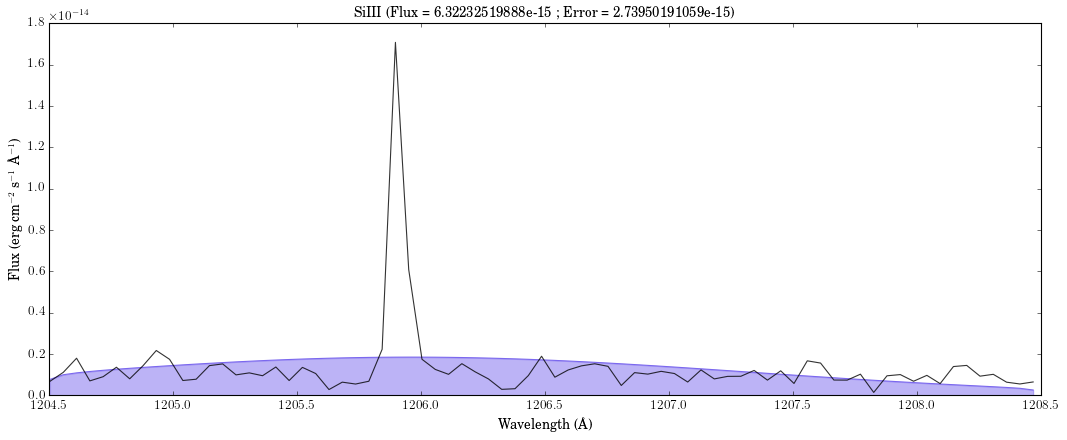

NV
[[1238.82, 1242.806]]
[[2, 2]]
1200
Spectra/K2-25/od9001020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9003010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9004020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9006010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9002030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9001030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9005010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9002020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9005020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9006030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9003020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9001010_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9005030_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9006020_x1d.fits G140M 1
Fitting gaussian
Spectra/K2-25/od9004010_x1d.fits G140M 1
Fitting gaussian
150
150
Number of peaks: 2
Peak:  1238.82
[  1.65108255e-16   1.23817783e+03   1.53460197e+

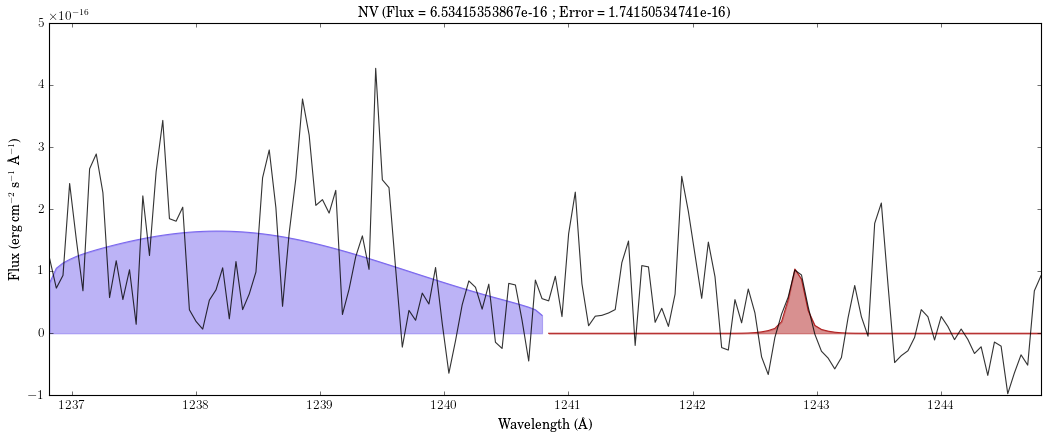

SiII
[[1260.42, 1265.0]]
[[0.7, 1]]
1200
No STIS observations for this line
CII
[[1335.71]]
[[0.7]]
1200
No STIS observations for this line
SiIV
[[1393.76, 1402.77]]
[[1, 1]]
1500
No STIS observations for this line
CIV
[[1548.19, 1550.78]]
[[1, 1]]
1500
No STIS observations for this line
HeII
[[1640.4]]
[[1]]
1700
No STIS observations for this line
MgII
[[2800.0]]
[[20]]
2400
No STIS observations for this line


In [925]:
#line_names = ["CIV"]
#line_waves = [[1548.19,1550.78]]
#line_windows = [[1,1]]

all_stis_total_fluxes = []
all_stis_total_fluxes_err = []
all_fluxes = []
all_fluxes_err = []
all_fit_params = []
all_fit_params_err = []

for line in line_names:
    print(line)
    
    peaks = np.array(line_waves)[np.array(line_names)==line]
    print(peaks)
    
    windows = np.array(line_windows)[np.array(line_names)==line]
    print(windows)
    
    lsf_center_wave = np.array(stis_grating_proxies)[np.array(line_names)==line][0]
    print(lsf_center_wave)
    
    all_line_waves = []
    all_line_fluxes = []
    
    # loop through each grating that can be used on a certain line
    for j in range(len(lines_stis_gratings[line])):
        #print(grating)
        
        # look at all stis spectra and get the grating and column info
        for i in range(len(stis_spectra_and_gratings)):
            grating = lines_stis_gratings[line][j]
            
            if grating == stis_spectra_and_gratings[i][1]:
                spectrum = stis_spectra_and_gratings[i][0]
                aperture = stis_spectra_and_gratings[i][2]
                
                if aperture == '52X0.05':
                    aperture = '52X0.1'
                
                grating_lsf_table = ascii.read("HST_Gratings/stis_%s_%s.txt" % (grating, lsf_center_wave))
                column = list(grating_lsf_table.dtype.names).index(str(aperture))
                print(spectrum, grating, column)
                
                stis_hdu = pyfits.open(spectrum)
                wave = np.ravel(stis_hdu[1].data["WAVELENGTH"]) / (1 + target_rv / c)
                flux = np.ravel(stis_hdu[1].data["FLUX"])
                err = np.ravel(stis_hdu[1].data["ERROR"])
                
                index_range = np.where((wave > np.array(peaks[0][0])-max(np.array(windows[0]))) & 
                                       (wave < np.array(peaks[0][-1])+max(np.array(windows[0]))))
                
                lsf = np.loadtxt("HST_Gratings/stis_%s_%s.txt" % (grating, lsf_center_wave), skiprows=1)
                dispersion = wave[1]-wave[0] # number of Å per pixel
                lsf_kernel = ready_lsf(lsf[:,0], lsf[:,column], dispersion, wave)
                
                #If the mean of the first 10% of values or last 10% of values is zero, cut that spectrum
                short_lo_flux = flux[index_range][:(0.2*len(flux[index_range]))]
                short_hi_flux = flux[index_range][:-(0.2*len(flux[index_range]))]
                
                if (mean(short_lo_flux) == 0 or mean(short_hi_flux) == 0):
                    print("Flat in range -- cannot fit line")
                    plt.figure()
                    plt.plot(wave,flux, color="red")
                    plt.xlim(np.array(peaks[0][0])-max(np.array(windows[0])),np.array(peaks[0][-1])+max(np.array(windows[0])))
                    plt.ylim(0,1.1*max(flux[index_range]))
                    plt.ticklabel_format(useOffset=False)
                    plt.show()
                    plt.close()
                else:
                    print("Fitting gaussian")
                    """plt.figure()
                    plt.plot(wave,flux, color="green")
                    plt.xlim(np.array(peaks[0][0])-max(np.array(windows[0])),np.array(peaks[0][-1])+max(np.array(windows[0])))
                    plt.ylim(0,1.1*max(flux[index_range]))
                    plt.ticklabel_format(useOffset=False)
                    plt.show()
                    plt.close()"""
                    
                    #print(len(wave[index_range]), len(flux[index_range]))
                    all_line_waves.append(wave[index_range])
                    all_line_fluxes.append(flux[index_range])
    
    # Not fitting anything for lines where no grating available matched that line
    if len(all_line_waves) == 0:
        print("No STIS observations for this line")
        
        for j in range(len(peaks[0])):
            all_fit_params.append(np.zeros(6))
            all_fit_params_err.append(np.zeros(6))
            all_fluxes.append(0)
            all_fluxes_err.append(0)
    
    else:
        min_wave = np.min(all_line_waves[0])
        max_wave = np.max(all_line_waves[-1])

        wave_array = np.linspace(min_wave,max_wave,len(all_line_fluxes[0]))

        all_line_interp = []
        for i in range(len(all_line_waves)):
            line_interp = np.interp(wave_array,all_line_waves[i],all_line_fluxes[i])
            all_line_interp.append(line_interp)

        avg_flux = np.mean(all_line_interp, axis=0)
        print(len(wave_array))
        print(len(avg_flux))

        #############################################
        #####     NOW FIT CO-ADDED SPECTRA     #####
        #############################################

        plt.figure(figsize=(16,6))
        plt.xlabel("Wavelength (\AA)")
        plt.ylabel("Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)")
        plt.xlim(np.array(peaks[0][0])-max(np.array(windows[0])),np.array(peaks[0][-1])+max(np.array(windows[0])))
        plt.ticklabel_format(useOffset=False)

        line_total_integral = []
        line_total_integral_err = []
        fit_parameters = []
        fit_err_parameters = []

        wave = wave_array
        flux = avg_flux

        for j in range(len(peaks[0])):
            print("Number of peaks:", len(peaks[0]))
            peak = peaks[0][j]
            window = windows[0][j]
            print("Peak: ", peak)

            if peak == 1265.0:
                print("Fitting a double gaussian")
                amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
                amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])

                p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)

                popt_dg, pcov_dg = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                           np.array(flux[(wave<1265.5) & (wave>1264)]), p0 = p0_dg, maxfev=2500)
                popt_dg_err = np.sqrt(np.diag(pcov_dg))
                                
                print(popt_dg)
                print(popt_dg_err)

                fit_parameters.append(popt_dg)
                fit_err_parameters.append(popt_dg_err)
                all_fit_params.append(popt_dg)
                all_fit_params_err.append(popt_dg_err)

                dg = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                             popt_dg[0], popt_dg[1], abs(popt_dg[2]), popt_dg[3], popt_dg[4], abs(popt_dg[5])) #, popt_g[6])

                int_dg = popt_dg[0] * popt_dg[2] * np.sqrt(2*pi) + popt_dg[3] * popt_dg[5] * np.sqrt(2*pi)
                int_dg_err = np.sqrt((np.sqrt(2*pi))**2 * (popt_dg_err[0]**2 * popt_dg[2]**2 + popt_dg_err[2]**2 * popt_dg[0]**2 
                                                   + popt_dg_err[3]**2 * popt_dg[5]**2 + popt_dg_err[5]**2 * popt_dg[3]**2))

                all_fluxes.append(int_dg)
                all_fluxes_err.append(int_dg_err)
                line_total_integral.append(int_dg)
                print("DOUBLE GAUSSIAN FLUX: ", int_dg)
                line_total_integral_err.append(int_dg_err)
                print("ERROR (DOUBLE GAUSSIAN FLUX): ", int_dg_err)

                plt.plot(wave[(wave<1265.5) & (wave>1264)], dg, alpha=1, color=colors[j])
                plt.fill_between(wave[(wave<1265.5) & (wave>1264)], dg, alpha=0.5, color=colors[j]) #label="Double Gaussian",

            elif peak == 2800.0:
                print("Fitting a double gaussian")
                amp1 = np.max(flux[(wave<2799) & (wave>2795)])
                amp2 = np.max(flux[(wave<2806) & (wave>2801)])

                p0_dg = generate_p0_dg(amp1, amp2, 2796.35, 2803.53, window)

                popt_dg, pcov_dg = curve_fit(double_gauss, np.array(wave[(wave<(peak+window)) & (wave>(peak-window))]), 
                                           np.array(flux[(wave<(peak+window)) & (wave>(peak-window))]), p0 = p0_dg, maxfev=2500)
                popt_dg_err = np.sqrt(np.diag(pcov_dg))
                                
                print(popt_dg)
                print(popt_dg_err)

                fit_parameters.append(popt_dg)
                fit_err_parameters.append(popt_dg_err)
                all_fit_params.append(popt_dg)
                all_fit_params_err.append(popt_dg_err)
                
                dg = double_gauss(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                             popt_dg[0], popt_dg[1], abs(popt_dg[2]), popt_dg[3], popt_dg[4], abs(popt_dg[5]))

                int_dg = popt_dg[0] * popt_dg[2] * np.sqrt(2*pi) + popt_dg[3] * popt_dg[5] * np.sqrt(2*pi)
                int_dg_err = np.sqrt((np.sqrt(2*pi))**2 * (popt_dg_err[0]**2 * popt_dg[2]**2 + popt_dg_err[2]**2 * popt_dg[0]**2 
                                                   + popt_dg_err[3]**2 * popt_dg[5]**2 + popt_dg_err[5]**2 * popt_dg[3]**2))

                all_fluxes.append(int_dg)
                all_fluxes_err.append(int_dg_err)
                line_total_integral.append(int_dg)
                print("DOUBLE GAUSSIAN FLUX: ", int_dg)
                line_total_integral_err.append(int_dg_err)
                print("ERROR (DOUBLE GAUSSIAN FLUX): ", int_dg_err)

                plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], dg, alpha=1, color=colors[j])
                plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                 dg, alpha=0.5, color=colors[j]) #label="Double Gaussian",

            else:
                peak_flux = np.max(flux[(wave<(peak+0.2)) & (wave>(peak-0.2))])

                p0_g = generate_p0_g(peak_flux, peak, window)

                #param_bounds=([peak_flux*.8,line-0.1,0,0],[peak_flux*1.2,line+0.1,0.8,0])
                popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                           flux[(wave<(peak+window)) & (wave>(peak-window))], p0 = p0_g, maxfev=2500)
                popt_g_err = np.sqrt(np.diag(pcov_g))
                
                print(popt_g)
                print(popt_g_err)

                fit_parameters.append(np.concatenate((popt_g, np.zeros(3))))
                fit_err_parameters.append(np.concatenate((np.sqrt(np.diag(pcov_g)), np.zeros(3))))
                all_fit_params.append(np.concatenate((popt_g, np.zeros(3))))
                all_fit_params_err.append(np.concatenate((np.sqrt(np.diag(pcov_g)), np.zeros(3))))
                
                g = gaussian(wave[(wave<(peak+window)) & (wave>(peak-window))], popt_g[0], popt_g[1], abs(popt_g[2]))

                int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
                int_g_err = np.sqrt((np.sqrt(2*pi))**2 * (popt_g_err[0]**2 * popt_g[2]**2 + popt_g_err[2]**2 * popt_g[0]**2))

                all_fluxes.append(int_g)
                all_fluxes_err.append(int_g_err)
                line_total_integral.append(int_g)
                print("GAUSSIAN FLUX:", int_g)
                line_total_integral_err.append(int_g_err)
                print("ERROR (GAUSSIAN FLUX):", int_g_err)

                plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], g, alpha=1, color=colors[j])
                plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                 g, alpha=0.5, color=colors[j]) #label="Gaussian",
                
        all_stis_total_fluxes.append(sum(line_total_integral))
        all_stis_total_fluxes_err.append(np.sqrt(sum(np.array(line_total_integral_err)**2)))

        #plt.ylim(0,1.1*np.max(flux[(wave<(peaks[0][-1]+np.max(peaks[0]))) & (wave>(peaks[0]-np.max(peaks[0])))]))
        total_flux = sum(line_total_integral)
        total_flux_err = np.sqrt(sum(np.array(line_total_integral_err)**2))
        plt.plot(wave_array, avg_flux, alpha=0.8, color="black")
        #legend = plt.legend(loc="best", fontsize=12)
        plt.title(r"%s (Flux = %s ; Error = %s)" % (line, total_flux, total_flux_err))
        plt.savefig("Graphs/%s_stis_%s" % (star, line))
        plt.show()

In [922]:
all_fit_params = np.array(all_fit_params)
all_fit_params_err = np.array(all_fit_params_err)

all_names = ['line', 'all_fluxes', 'all_fluxes_err',
             'amp1', 'amp1_err', 'cen1', 'cen1_err', 'wid1', 'wid1_err',
             'amp2', 'amp2_err', 'cen2', 'cen2_err', 'wid2', 'wid2_err']
data = Table({'line': all_lines, 'all_fluxes': all_fluxes, 'all_fluxes_err': all_fluxes_err,
              'amp1': all_fit_params[:,0], 'amp1_err': all_fit_params_err[:,0],
              'cen1': all_fit_params[:,1], 'cen1_err': all_fit_params_err[:,1],
              'wid1': all_fit_params[:,2], 'wid1_err': all_fit_params_err[:,2],
              'amp2': all_fit_params[:,3], 'amp2_err': all_fit_params_err[:,3],
              'cen2': all_fit_params[:,4], 'cen2_err': all_fit_params_err[:,4],
              'wid2': all_fit_params[:,5], 'wid2_err': all_fit_params_err[:,5]}, names=all_names)

ascii.write(data, 'Spectra/%s/uv_stis_fit_parameters.txt' % star, overwrite=True)

ValueError: Inconsistent data column lengths: set([10, 12])

('Rel', '52X0.1', '52X0.2', '52X0.5', '52X2.0')
2400
GJ3053


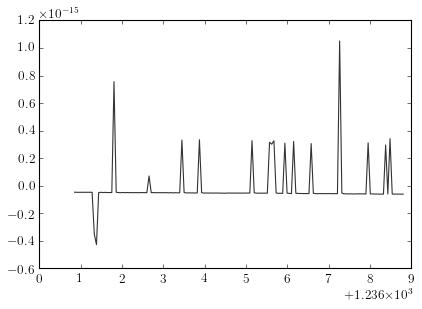

In [896]:
print(grating_lsf_table.dtype.names)
print(lsf_center_wave)
print(star)
plt.plot(wave_array, avg_flux, alpha=0.8, color="black")

## Average STIS and COS Results for Spreadsheet

In [824]:
print(all_cos_total_fluxes)
print(all_cos_total_fluxes_err)

print(all_stis_total_fluxes)
print(all_stis_total_fluxes_err)

NV_means = np.average(np.array([6.5971669246510602e-16, 3.2981552427000535e-16]), 
                      weights=1/((np.array([1.3141958755658275e-17,6.0321735655655672e-17])**2)))
NV_means_err = 1/sum(1/((np.array([1.3141958755658275e-17,6.0321735655655672e-17])**2)))
print(NV_means, NV_means_err)

[3.2686226592061585e-16, 6.5971672673707132e-16, 9.4905763917802396e-17, 6.4588293645116014e-16, 3.576879031577385e-16]
[1.0632642926785758e-17, 1.3141964550850146e-17, 1.1443836375763431e-17, 2.1413701883677361e-17, 1.6450506696601903e-17]
[2.0645173384311029e-17, 3.2981565410484778e-16]
[1.0207008312681783e-09, 6.0321624542300613e-17]
6.44767528088e-16 1.64884838101e-34







## OLD PRACTICE CODE

In [ ]:
            """elif line == "HeII":
            peak_flux = np.max(flux[(wave<(peak+0.2)) & (wave>(peak-0.2))])

            p0_g = generate_p0_v(peak_flux, peak, window)

            popt_g, pcov_g = curve_fit(voigt, wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                       flux[(wave<(peak+window)) & (wave>(peak-window))], p0 = p0_g, maxfev=2500)

            g = voigt(wave[(wave<(peak+window)) & (wave>(peak-window))], popt_g[0], popt_g[1], abs(popt_g[2]), abs(popt_g[2]))

            int_g = np.trapz(g, wave[(wave<(peak+window)) & (wave>(peak-window))], 0.002)

            line_total_integral.append(int_g)
            print("GAUSSIAN FLUX:", int_g)

            plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], g, alpha=1, color=colors[j])
            plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                             g, alpha=0.5, label="Voigt", color=colors[j])"""

Fitting a double gaussian
DOUBLE GAUSSIAN FLUX: 1.29029236843e-13


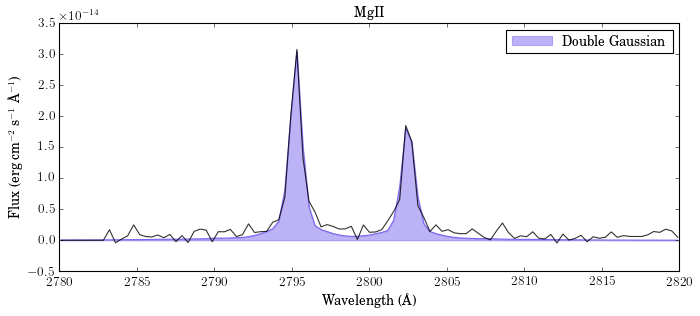

In [326]:
    min_wave = np.min(all_line_waves[0])
    max_wave = np.max(all_line_waves[-1])

    wave_array = np.linspace(min_wave,max_wave,len(all_line_fluxes[0]))

    avg_flux = np.mean(all_line_fluxes, axis=0)
    #print(len(wave_array))
    #print(len(avg_flux))

    #############################################
    #####     NOW FIT CO-ADDED SPECTRA     #####
    #############################################

    plt.figure(figsize=(10,4))
    plt.xlabel("Wavelength (\AA)")
    plt.ylabel("Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)")
    plt.xlim(np.array(peaks[0][0])-max(np.array(windows)),np.array(peaks[0][-1])+max(np.array(windows)))
    plt.title(r"%s" % line)
    plt.ticklabel_format(useOffset=False)

    line_total_integral = []

    for j in range(len(peaks)):
        peak = peaks[0][j]
        window = windows[0][j]

        if peak == 1265:
            print("Fitting a double gaussian")
            amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
            amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])

            p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)

            popt_dg, pcov_dg = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                       np.array(flux[(wave<1265.5) & (wave>1264)]), p0 = p0_dg, maxfev=2500)

            dg = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                         popt_dg[0], popt_dg[1], abs(popt_dg[2]), popt_dg[3], popt_dg[4], abs(popt_dg[5])) #, popt_g[6])


            int_dg = popt_dg[0] * popt_dg[2] * np.sqrt(2*pi) + popt_dg[3] * popt_dg[5] * np.sqrt(2*pi)

            line_total_integral.append(int_dg)
            print("DOUBLE GAUSSIAN FLUX: ", int_dg)

            plt.plot(wave[(wave<1265.5) & (wave>1264)], dg, alpha=1, color=colors[j])
            plt.fill_between(wave[(wave<1265.5) & (wave>1264)], dg, alpha=0.5, label="Double Gaussian", color=colors[j])

        if peak == 2800:
            print("Fitting a double gaussian")
            amp1 = np.max(flux[(wave<2799) & (wave>2795)])
            amp2 = np.max(flux[(wave<2806) & (wave>2801)])

            p0_dg = generate_p0_dg(amp1, amp2, 2796.35, 2803.53, window)

            popt_dg, pcov_dg = curve_fit(double_gauss, np.array(wave[(wave<(peak+window)) & (wave>(peak-window))]), 
                                       np.array(flux[(wave<(peak+window)) & (wave>(peak-window))]), p0 = p0_dg, maxfev=2500)

            dg = double_gauss(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                         popt_dg[0], popt_dg[1], abs(popt_dg[2]), popt_dg[3], popt_dg[4], abs(popt_dg[5]))

            int_dg = popt_dg[0] * popt_dg[2] * np.sqrt(2*pi) + popt_dg[3] * popt_dg[5] * np.sqrt(2*pi)

            line_total_integral.append(int_g)
            print("DOUBLE GAUSSIAN FLUX:", int_dg)

            plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], dg, alpha=1, color=colors[j])
            plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                             dg, alpha=0.5, label="Double Gaussian", color=colors[j])

        else:
            peak_flux = np.max(flux[(wave<(peak+0.2)) & (wave>(peak-0.2))])

            p0_g = generate_p0_g(peak_flux, peak, window)

            popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(peak+window)) & (wave>(peak-window))], 
                                       flux[(wave<(peak+window)) & (wave>(peak-window))], p0 = p0_g, maxfev=2500)

            g = gaussian(wave[(wave<(peak+window)) & (wave>(peak-window))], popt_g[0], popt_g[1], abs(popt_g[2]))

            int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)

            line_total_integral.append(int_g)
            print("GAUSSIAN FLUX:", int_g)

            plt.plot(wave[(wave<(peak+window)) & (wave>(peak-window))], g, alpha=1, color=colors[j])
            plt.fill_between(wave[(wave<(peak+window)) & (wave>(peak-window))], 
                             g, alpha=0.5, label="Gaussian", color=colors[j]) 

    #plt.ylim(0,1.1*np.max(flux[(wave<(peaks[0][-1]+np.max(peaks[0]))) & (wave>(peaks[0]-np.max(peaks[0])))]))
    plt.plot(wave_array, avg_flux, alpha=0.8, color="black")
    legend = plt.legend(loc="best", fontsize=12)
    legend.get_title().set_fontsize('14')
    plt.savefig("Graphs/%s_cos_%s" % (star, line))
    plt.show()

In [263]:
print(peaks[0][0])
print(windows[0])

hdu = pyfits.open("Spectra/test_uv_spectra/ldab33huq_x1d.fits")
print(hdu[0].header["OPT_ELEM"])

2796.35
[20]
G230L


In [82]:
for grating in all_cos_gratings:
    print(grating)

    filenames = all_cos_gratings[grating]
    print(filenames)
    
    if len(filenames) > 0:

        all_orders_wave = []
        all_orders_flux = []

        for name in filenames:

            spec_hdu = pyfits.open(name)
            spec = spec_hdu[1].data
            spec_header = spec_hdu[1].header

            all_orders_wave.append(np.ravel(spec["WAVELENGTH"])/ (1 + target_rv / c))
            all_orders_flux.append(np.ravel(spec["FLUX"]))
        
        all_orders_wave = np.array(all_orders_wave)
        all_orders_flux = np.array(all_orders_flux)

        min_wave = np.max(all_orders_wave[:,0])
        max_wave = np.min(all_orders_wave[:,-1])
        print("Min: ", min_wave, "Max: ", max_wave)

        wave_array = np.arange(min_wave,max_wave,0.01) #what should I use for separation between wavelengths?

        #plt.figure(figsize=(14,4))

        all_orders_interp = []
        for i in range(len(filenames)):
            output = np.array(np.where((all_orders_wave[i] >= min_wave) & (all_orders_wave[i] <= max_wave)))
            print(len(output[0]))
            print(output)
            order_interp = np.interp(wave_array,all_orders_wave[i],all_orders_flux[i])
            all_orders_interp.append(order_interp)
            #plt.plot(wave_array,order_interp)

        flux_array = np.zeros(len(wave_array))
        error_array = np.zeros(len(wave_array))
        all_orders_interp = np.array(all_orders_interp)

        for i in range(len(filenames)-1):
            overlap = (wave_array >= np.min(all_orders_wave[i+1])) & (wave_array <= np.max(all_orders_wave[i]))
            flux_array[overlap] = (all_orders_interp[i][overlap] + all_orders_interp[i+1][overlap])/2.

        for i in range(len(filenames)):
            if i == 0:
                order_mask = wave_array <= np.min(all_orders_wave[i+1])
                flux_array[order_mask] = all_orders_interp[i][order_mask]
            if i == (len(filenames)-1):
                order_mask = wave_array >= np.max(all_orders_wave[i-1])
                flux_array[order_mask] = all_orders_interp[i][order_mask]
            else:
                order_mask = (wave_array >= np.max(all_orders_wave[i-1])) & (wave_array <= np.min(all_orders_wave[i+1]))
                flux_array[order_mask] = all_orders_interp[i][order_mask]

        #print(flux_array)

        #plt.figure(figsize=(14,4))
        #plt.plot(wave_array,flux_array)

        np.savetxt('Spectra/%s/%s_%s.txt' % ("test_uv_spectra", "test_uv_spectra", grating),
                   np.transpose(np.array([wave_array,flux_array])))

    break

cos_NUV
['Spectra/test_uv_spectra/ldab33hsq_x1d.fits', 'Spectra/test_uv_spectra/ldab33huq_x1d.fits']
Min:  1630.38583664 Max:  2175.75432174
2547
[[   0    1    2 ..., 3818 3819 3820]]
2547
[[   1    2    3 ..., 3819 3820 3821]]


Wavelength Range:  1374.66933446 1763.49759908


(2700, 2815)

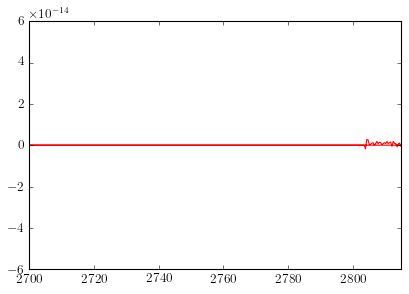

In [101]:
wave = np.ravel(cos_hdu[1].data["WAVELENGTH"]) / (1 + target_rv / c)
flux = np.ravel(cos_hdu[1].data["FLUX"])
err = np.ravel(cos_hdu[1].data["ERROR"])

print("Wavelength Range: ", min(wave), max(wave))

plt.plot(all_orders_wave[0], all_orders_flux[0], color="red")
#plt.plot(all_orders_wave[1], all_orders_flux[1], color="blue")
plt.xlim(2700,2815)


(1540, 1560)

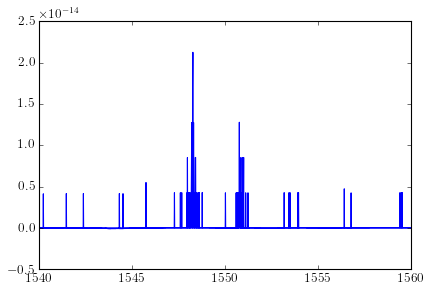

In [7]:
plt.plot(wave, flux)
plt.xlim(1540,1560)

In [74]:
lsf = np.loadtxt("HST_Gratings/cos_%s.txt" % cos_grating, skiprows=1)
dispersion = wave[1]-wave[0] # number of Å per pixel
lsf_kernel = ready_lsf(lsf[:,0], lsf[:,1], dispersion, wave)

In [75]:
print(lsf)

[[ -5.00000000e+01   1.01100000e-04   9.48500000e-05   9.12300000e-05
    8.84400000e-05   8.76900000e-05   8.71100000e-05   8.76400000e-05]
 [ -4.90000000e+01   1.05900000e-04   1.00300000e-04   9.70300000e-05
    9.49000000e-05   9.52600000e-05   9.47900000e-05   9.69600000e-05]
 [ -4.80000000e+01   1.11500000e-04   1.06500000e-04   1.03700000e-04
    1.02600000e-04   1.03500000e-04   1.03700000e-04   1.07600000e-04]
 [ -4.70000000e+01   1.17900000e-04   1.13600000e-04   1.11700000e-04
    1.11600000e-04   1.12600000e-04   1.14100000e-04   1.18500000e-04]
 [ -4.60000000e+01   1.25600000e-04   1.22200000e-04   1.21100000e-04
    1.21700000e-04   1.23000000e-04   1.25700000e-04   1.28800000e-04]
 [ -4.50000000e+01   1.34800000e-04   1.32400000e-04   1.31900000e-04
    1.33000000e-04   1.35200000e-04   1.37700000e-04   1.38600000e-04]
 [ -4.40000000e+01   1.46000000e-04   1.44100000e-04   1.44100000e-04
    1.46100000e-04   1.48500000e-04   1.49200000e-04   1.48700000e-04]
 [ -4.3000000

In [77]:
print(G130M)

NameError: name 'G130M' is not defined